In [1]:
from langgraph.graph import StateGraph, START, END, add_messages
from typing import TypedDict, Annotated, List
from langgraph.checkpoint.memory import MemorySaver
from langchain_groq import ChatGroq
from langchain_community.tools import TavilySearchResults
from langgraph.prebuilt import ToolNode
from langchain_core.messages import HumanMessage
from IPython.display import Image, display
from uuid import uuid4

In [2]:
memory=MemorySaver()

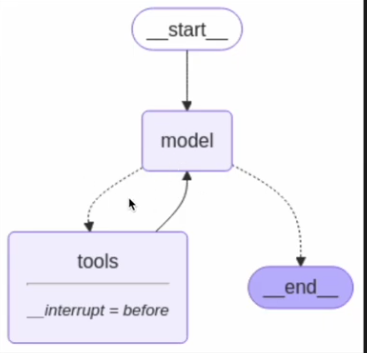

In [3]:
search_tool=TavilySearchResults(max_results=2)

In [4]:
tools=[search_tool]

In [5]:
llmLlama=ChatGroq(model="llama-3.1-8b-instant")

In [6]:
llm_with_tools=llmLlama.bind_tools(tools=tools)

In [7]:
class BasicState(TypedDict):
    messages:Annotated[List, add_messages]

In [8]:
def model(state:BasicState):
    state['message']=[llm_with_tools.invoke(input=state["messages"])]
    return state

In [9]:
def tools_router(state: BasicState):
    last_message=state['messages'][-1]
    if (hasattr(last_message,"tool_calls")) and len(last_message.tool_calls)>0:
        return "tools"
    else:
        return "end"

In [10]:
graph=StateGraph(BasicState)

In [11]:
graph.add_node(node="model",action=model)

In [12]:
graph.add_node(node="tools",action=ToolNode(tools=tools))

In [13]:
graph.add_conditional_edges(
    source="model",
    path=tools_router,
    path_map={
            "tools":"tools",
            "end":END
            })

In [14]:
graph.add_edge(start_key="tools",end_key="model")

In [15]:
graph.set_entry_point(key="model")

In [16]:
app=graph.compile(checkpointer=memory, interrupt_before=["tools"])

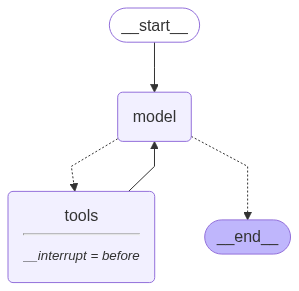

In [17]:
display(Image(data=app.get_graph().draw_mermaid_png()))

In [18]:
app.get_graph().print_ascii()

        +-----------+         
        | __start__ |         
        +-----------+         
              *               
              *               
              *               
          +-------+           
          | model |           
          +-------+           
         *         .          
       **           ..        
      *               .       
+-------+         +---------+ 
| tools |         | __end__ | 
+-------+         +---------+ 


In [19]:
config={
    "configurable":{
        "thread_id": uuid4()
    }
}
config

{'configurable': {'thread_id': UUID('eaac137d-7fbf-4f81-9913-68bdd8f51150')}}

In [20]:
events=app.stream(input={
    "messages": [HumanMessage(content="What is the current weather in Chennai?")]
}, config=config, stream_mode="values")

In [21]:
for event in events:
    print(event['messages'])
    print(event['messages'][-1],"\n")
    event['messages'][-1].pretty_print()
    print("\n")


[HumanMessage(content='What is the current weather in Chennai?', additional_kwargs={}, response_metadata={}, id='e90e5ec5-136a-4483-8827-83802bbc8c27')]
content='What is the current weather in Chennai?' additional_kwargs={} response_metadata={} id='e90e5ec5-136a-4483-8827-83802bbc8c27' 

================================ Human Message =================================

What is the current weather in Chennai?




BadRequestError: Error code: 400 - {'error': {'message': "Failed to call a function. Please adjust your prompt. See 'failed_generation' for more details.", 'type': 'invalid_request_error', 'code': 'tool_use_failed', 'failed_generation': '<function=tavily_search_results_json>{"query": "Current weather in Chennai"}"</function>'}}

In [ ]:
snapshot=app.get_state(config=config)

In [ ]:
snapshot.next

()

In [ ]:
events=app.stream(input=None, config=config, stream_mode="values")

In [ ]:
for event in events:
    print(event['messages'])
    print(event['messages'][-1],"\n")
    event['messages'][-1].pretty_print()
    print("\n")

[HumanMessage(content='What is the current weather in Chennai?', additional_kwargs={}, response_metadata={}, id='30546de5-f0e2-441c-87dc-c8a6c96a3cb6')]
content='What is the current weather in Chennai?' additional_kwargs={} response_metadata={} id='30546de5-f0e2-441c-87dc-c8a6c96a3cb6' 

================================ Human Message =================================

What is the current weather in Chennai?


